In [1]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from myDataSet import *
from myNetworks import *
from myUtil import *
from tqdm import tqdm

In [2]:
# TODO: Implement GPU memory alloc in case of CUDA
# TODO: enable parallel GPU computation

In [3]:
# Set up the dataset.
image_directory = "Insects"
annotations_file_directory = "insects.csv"
image_dims = (520,520)
my_transform = torchvision.transforms.Resize(image_dims)
dataset = MyCustomImageDataset(annotations_file_dir=annotations_file_directory,
                               image_directory_path=image_directory,
                               transform=my_transform)

# Preparing data for learning (normalization, one-hot encoding and batching)
my_batch_size, my_data_fraction, my_test_fraction, my_validation_fraction = 4, 0.05, 0.2, 0.3
prepped_data = DataPrep(dataset=dataset,
                        batch_size=my_batch_size,
                        data_fraction=my_data_fraction,
                        test_fraction=my_test_fraction,
                        validation_fraction=my_validation_fraction)

my_X_train_batches, my_Y_train_batches = prepped_data.train_X, prepped_data.train_Y
my_X_validation_batches, my_Y_validation_batches = prepped_data.validation_X, prepped_data.validation_Y
print("Shape of single X batch: ",tuple(my_X_train_batches[0].shape))

Initial nr. of batches:  181
Nr. batches after 'data_fraction' splitting:  9
Nr. batches set aside for testing:  1
Nr. batches set aside for validation:  1
Nr. batches remaining for training:  7
Shape of single X batch:  (4, 3, 520, 520)


In [4]:
# Creating instance of neural network
my_nr_channels = my_X_train_batches[0].shape[1]
my_nr_classes = my_Y_train_batches[0].shape[1]
my_input_dimensions = (my_X_train_batches[0].shape[2], my_X_train_batches[0].shape[3])

my_net = NeuralNet2(channels_in=my_nr_channels,
                   nr_classes=my_nr_classes,
                   input_dimensions=my_input_dimensions)

In [5]:
train_accuracies, train_losses, validation_accuracies, validation_losses = my_net.train_network(
                                                        train_data_batches=my_X_train_batches,
                                                      train_labels_batches=my_Y_train_batches,
                                                   validation_data_batches=my_X_validation_batches,
                                                 validation_labels_batches=my_Y_validation_batches,
                                                                    epochs=6,
                                                               device_name='cpu')

 17%|█▋        | 1/6 [00:08<00:43,  8.72s/it]

Model saved at epoch:  1 , with validation acc:  100.0 %


100%|██████████| 6/6 [00:52<00:00,  8.70s/it]


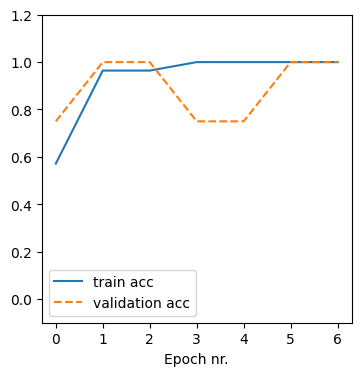

In [6]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
epochs = [i for i in range(len(train_accuracies))]
ax.plot(epochs,train_accuracies,label="train acc")
#ax.plot(epochs,train_losses,label="train loss")
ax.plot(epochs,validation_accuracies,ls='--',label="validation acc")
#ax.plot(epochs,test_losses,label="test loss")
ax.set_ylim(-0.1,1.2)
ax.set_xlabel("Epoch nr.")
ax.legend()
plt.show()

In [7]:
print(train_accuracies)

[tensor(0.5714), tensor(0.9643), tensor(0.9643), tensor(1.), tensor(1.), tensor(1.), tensor(1.)]


In [8]:
test_model(my_net,prepped_data)

Testing model on all available test batches..

 #####|  4 / 4  items in  1  test batches predicted correctly ~ acc:  1.0  |#####
